# Data preparation for Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

**Note:** This script is used to prepare the **development and test datasets**.
It is fully deterministic and does not involve any random sampling or shuffling.

In [1]:
import numpy as np
import os
import h5py 
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import kagglehub

from experiment_config import DATA_NAME

In [2]:
data_split = "dev" #"test" #

# Download data

In [3]:
ncmapss_dir = kagglehub.dataset_download("bishals098/nasa-cmapss-2-engine-degradation",force_download=False)

print("Path to dataset files:", ncmapss_dir)

Path to dataset files: /Users/abeldiaz/.cache/kagglehub/datasets/bishals098/nasa-cmapss-2-engine-degradation/versions/1


In [4]:
!ls {ncmapss_dir}

N-CMAPSS_DS01-005.h5
N-CMAPSS_DS02-006.h5
N-CMAPSS_DS03-012.h5
N-CMAPSS_DS04.h5
N-CMAPSS_DS05.h5
N-CMAPSS_DS06.h5
N-CMAPSS_DS07.h5
N-CMAPSS_DS08a-009.h5
N-CMAPSS_DS08c-008.h5
N-CMAPSS_Example_data_loading_and_exploration.ipynb
Run_to_Failure_Simulation_Under_Real_Flight_Conditions_Dataset.pdf


In [5]:

experiment_dir = Path('experiments')/DATA_NAME

## 1. Load data

In [6]:
#ncmapss_dir = '/media/macslab/phm2021_data_challenge/data_h5'
NCMAPSS_PATH={"DS01":f'{ncmapss_dir}/N-CMAPSS_DS01-005.h5', 
        "DS02":f'{ncmapss_dir}/N-CMAPSS_DS02-006.h5',
        "DS03":f'{ncmapss_dir}/N-CMAPSS_DS03-012.h5',
        "DS04":f'{ncmapss_dir}/N-CMAPSS_DS04.h5',
        "DS05":f'{ncmapss_dir}/N-CMAPSS_DS05.h5',
        "DS06":f'{ncmapss_dir}/N-CMAPSS_DS06.h5',
        "DS07":f'{ncmapss_dir}/N-CMAPSS_DS07.h5',
        "DS08a":f'{ncmapss_dir}/N-CMAPSS_DS08a-009.h5',
        "DS08c":f'{ncmapss_dir}/N-CMAPSS_DS08c-008.h5',
        #"DS08d":f'{ncmapss_dir}/N-CMAPSS_DS08d-010.h5', # broken file
}

In [7]:
block_keys = ["W", "X_s", "X_v", "T", "A", "RUL"]

# Metadata descriptions
block_description = {
    "W":   "Scenario descriptors",
    "X_s": "Measurements",
    "X_v": "Virtual sensors",
    "T":   "Health Parameters",
    "A":   "Auxiliary data",
    "RUL": "RUL (in cycles)",
}

 
with h5py.File(NCMAPSS_PATH[DATA_NAME], "r") as f:
	feature_keys = block_keys[:-1]  # all except RUL
	arrays = [f[f"{key}_{data_split}"][:] for key in feature_keys+['Y']]  # include Y_dev for later RUL
	arr = np.concatenate(arrays, axis=1)
	del arrays  # for memory efficiency
	
	col_group = {
		name: [item.decode("utf-8") for item in f[f"{name}_var"][:]]
		for name in feature_keys
	}
	col_group["RUL"] = ["RUL"]

columns = [col for name in block_keys for col in col_group[name]]

df= pd.DataFrame(arr, columns=columns)

del arr  # memory efficiency

## 2. Exploratory Data Analysis (EDA) 

In [8]:
for name,desc in block_description.items():
    print(f"{desc}({name}): {col_group[name]}")

Scenario descriptors(W): ['alt', 'Mach', 'TRA', 'T2']
Measurements(X_s): ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
Virtual sensors(X_v): ['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']
Health Parameters(T): ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
Auxiliary data(A): ['unit', 'cycle', 'Fc', 'hs']
RUL (in cycles)(RUL): ['RUL']


In [9]:
df.describe()

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL
count,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,...,4906636.0,4.906636e+06,4906636.0,4906636.0,4906636.0,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06
mean,1.568371e+04,5.384156e-01,6.059576e+01,4.902042e+02,5.696602e+02,1.330678e+03,1.640812e+03,1.129691e+03,1.293220e+01,1.008869e+01,...,0.0,-3.916843e-03,0.0,0.0,0.0,3.727439e+00,4.550336e+01,2.301987e+00,2.601379e-01,4.483609e+01
std,8.007308e+03,1.194006e-01,1.840391e+01,1.960585e+01,2.085329e+01,6.813023e+01,1.238026e+02,6.226462e+01,2.847409e+00,2.394340e+00,...,0.0,4.130068e-03,0.0,0.0,0.0,1.643444e+00,2.663813e+01,7.458150e-01,4.387097e-01,2.663873e+01
min,3.001000e+03,3.150000e-04,2.355452e+01,4.213779e+02,4.841972e+02,1.069983e+03,9.550565e+02,6.984278e+02,5.917596e+00,4.373175e+00,...,0.0,-1.866833e-02,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,9.206000e+03,4.440240e-01,4.684537e+01,4.744894e+02,5.548824e+02,1.285256e+03,1.556507e+03,1.086167e+03,1.052334e+01,7.996442e+00,...,0.0,-5.103756e-03,0.0,0.0,0.0,2.000000e+00,2.300000e+01,2.000000e+00,0.000000e+00,2.200000e+01
50%,1.465400e+04,5.481000e-01,6.539016e+01,4.940213e+02,5.672901e+02,1.326394e+03,1.649059e+03,1.119625e+03,1.309985e+01,1.030762e+01,...,0.0,-2.021750e-03,0.0,0.0,0.0,4.000000e+00,4.500000e+01,2.000000e+00,0.000000e+00,4.400000e+01
75%,2.235100e+04,6.383160e-01,7.707953e+01,5.063441e+02,5.831270e+02,1.369856e+03,1.719067e+03,1.164322e+03,1.517187e+01,1.197260e+01,...,0.0,-1.130950e-03,0.0,0.0,0.0,5.000000e+00,6.700000e+01,3.000000e+00,1.000000e+00,6.700000e+01
max,3.503300e+04,7.492590e-01,8.876890e+01,5.343834e+02,6.340001e+02,1.525869e+03,1.986323e+03,1.357899e+03,2.044808e+01,1.568410e+01,...,0.0,-1.173363e-04,0.0,0.0,0.0,6.000000e+00,1.000000e+02,3.000000e+00,1.000000e+00,9.900000e+01


### Dtype

In [10]:
df.dtypes

alt             float64
Mach            float64
TRA             float64
T2              float64
T24             float64
T30             float64
T48             float64
T50             float64
P15             float64
P2              float64
P21             float64
P24             float64
Ps30            float64
P40             float64
P50             float64
Nf              float64
Nc              float64
Wf              float64
T40             float64
P30             float64
P45             float64
W21             float64
W22             float64
W25             float64
W31             float64
W32             float64
W48             float64
W50             float64
SmFan           float64
SmLPC           float64
SmHPC           float64
phi             float64
fan_eff_mod     float64
fan_flow_mod    float64
LPC_eff_mod     float64
LPC_flow_mod    float64
HPC_eff_mod     float64
HPC_flow_mod    float64
HPT_eff_mod     float64
HPT_flow_mod    float64
LPT_eff_mod     float64
LPT_flow_mod    

### Nan values

In [11]:
df.isna().sum()

alt             0
Mach            0
TRA             0
T2              0
T24             0
T30             0
T48             0
T50             0
P15             0
P2              0
P21             0
P24             0
Ps30            0
P40             0
P50             0
Nf              0
Nc              0
Wf              0
T40             0
P30             0
P45             0
W21             0
W22             0
W25             0
W31             0
W32             0
W48             0
W50             0
SmFan           0
SmLPC           0
SmHPC           0
phi             0
fan_eff_mod     0
fan_flow_mod    0
LPC_eff_mod     0
LPC_flow_mod    0
HPC_eff_mod     0
HPC_flow_mod    0
HPT_eff_mod     0
HPT_flow_mod    0
LPT_eff_mod     0
LPT_flow_mod    0
unit            0
cycle           0
Fc              0
hs              0
RUL             0
dtype: int64

### Unique values

In [12]:
#df.nunique()
df['Fc'].unique()

array([1., 3., 2.])

In [13]:
df['Fc'] = df['Fc'].astype(int)

## 3 Preprocessing

* Change the sensor readings  from double-precision floating-point format to half-precision  floating-point format
* Separate by units 
* Reduce the sampling frequency from  1Hz to 0.1Hz by decimation

In [14]:
df[col_group["X_s"]]=df[col_group["X_s"]].apply(lambda x: x.astype(np.float32))
df[col_group["X_v"]]=df[col_group["X_v"]].apply(lambda x: x.astype(np.float32))

In [15]:
df

,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,P2,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL
0,3013.0,0.376362,70.311996,522.314770,618.288574,1470.469849,1849.620728,1269.275635,19.432070,14.484612,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
1,3020.0,0.376866,70.311996,522.327145,618.296326,1470.415649,1849.519897,1269.177124,19.431385,14.484683,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
2,3025.0,0.377685,70.311996,522.371840,618.336487,1470.453857,1849.566162,1269.167358,19.435163,14.488223,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
3,3035.0,0.376992,70.399887,522.282418,618.302185,1470.650879,1850.195068,1269.518677,19.426003,14.477633,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
4,3043.0,0.377622,70.399887,522.300605,618.345215,1470.640381,1849.950928,1269.254028,19.427485,14.478113,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4906631,3030.0,0.201159,31.728291,511.974677,570.015076,1285.435181,1555.520386,1164.991699,16.109127,13.492444,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
4906632,3021.0,0.203238,31.728291,512.092657,570.111938,1285.592407,1555.936279,1165.280273,16.121885,13.504848,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
4906633,3015.0,0.202986,31.728291,512.103385,570.136963,1285.638550,1555.788940,1165.146606,16.124832,13.506798,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
4906634,3007.0,0.203301,31.728291,512.145375,570.176575,1285.711670,1555.959473,1165.285645,16.130621,13.512027,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0


In [16]:
df['unit'].unique()

array([1., 2., 3., 4., 5., 6.])

In [17]:
df_downsampled = (
    df.groupby("unit")
      .nth(range(0, len(df), 10))
      .reset_index()
)
df_downsampled

,index,alt,Mach,TRA,T2,T24,T30,T48,T50,P15,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,unit,cycle,Fc,hs,RUL
0,0,3013.0,0.376362,70.311996,522.314770,618.288574,1470.469849,1849.620728,1269.275635,19.432070,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
1,10,3088.0,0.379827,70.399887,522.305436,618.331360,1470.455078,1849.592651,1268.837402,19.415831,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
2,20,3163.0,0.385497,70.575668,522.470679,618.648010,1471.080688,1850.528564,1268.775269,19.426363,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
3,30,3234.0,0.390915,70.575668,522.636427,618.811707,1471.019775,1850.052002,1268.011475,19.427917,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
4,40,3308.0,0.394317,70.575668,522.635789,618.783264,1470.717163,1849.456421,1267.325317,19.407980,...,0.0,-0.000604,0.0,0.0,0.0,1.0,1.0,1,1.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490661,4906586,3346.0,0.205758,31.991961,511.028314,569.180115,1284.297485,1554.897095,1163.393555,15.953566,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
490662,4906596,3297.0,0.206073,31.728291,511.216516,569.105835,1283.406250,1553.072144,1162.902710,15.969251,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
490663,4906606,3228.0,0.196749,31.728291,511.085922,569.061340,1283.575073,1553.374878,1163.461060,15.974545,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0
490664,4906616,3150.0,0.199647,31.728291,511.481771,569.463989,1284.355591,1554.506104,1164.269775,16.031763,...,0.0,-0.017792,0.0,0.0,0.0,6.0,94.0,2,0.0,0.0


## 3.2 Operation Condition Normalization Procedure

Learn $f: X\mapsto Y$ frp, the flight conditions $X$ to the sensor outputs $Y$

$X$ Consist of 6 features, 4 flight conditions, 
* flight mach number (mach)
* altitude (alt)
* throttle resolve angle (TRA) 
* total fan inlet temperature (T2)
* flight class (a categorical feature describing the  flight length)
* positional variable of time elapsed within  the flight cycle (ranging from 0 to 1 within each cycle)

**Note:** The paper says 5 features but they enumerate 6. 

### Get operation conditions

unit
1.0    Axes(0.125,0.11;0.775x0.77)
2.0    Axes(0.125,0.11;0.775x0.77)
3.0    Axes(0.125,0.11;0.775x0.77)
4.0    Axes(0.125,0.11;0.775x0.77)
5.0    Axes(0.125,0.11;0.775x0.77)
6.0    Axes(0.125,0.11;0.775x0.77)
dtype: object

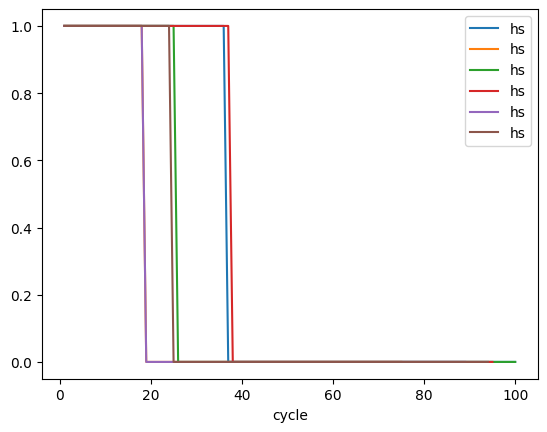

In [18]:
fig, ax = plt.subplots()
df_downsampled.groupby("unit").plot(x="cycle", y="hs", ax=ax, legend=True)

In [19]:
def add_positional_encoding(df: pd.DataFrame) -> None:
	"""Add a normalized positional encoding column to the dataframe.

	The positional encoding is calculated within each cycle group,
	normalized between 0 and 1.

	Args:
		df (pd.DataFrame): Input dataframe with 'cycle' column.
	"""

	df["cycle_id"] = (df["cycle"] != df["cycle"].shift()).cumsum()

	df["pos"] = (
		df.groupby("cycle_id")
		.cumcount()
		/
		(df.groupby("cycle_id")["cycle"].transform("size") - 1)
	)
	del df["cycle_id"]
	df["pos"] = df["pos"].fillna(0.0)

In [20]:
add_positional_encoding(df_downsampled)

<Axes: >

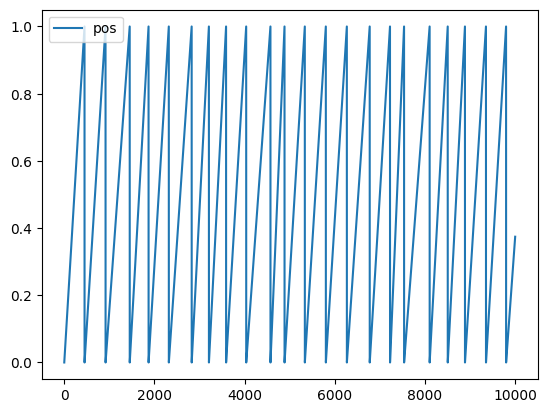

In [21]:
df_downsampled[:10000].plot(y="pos")

In [22]:
operation_cond_cols=col_group['W']+['Fc']+['pos']
operation_cond_cols

['alt', 'Mach', 'TRA', 'T2', 'Fc', 'pos']

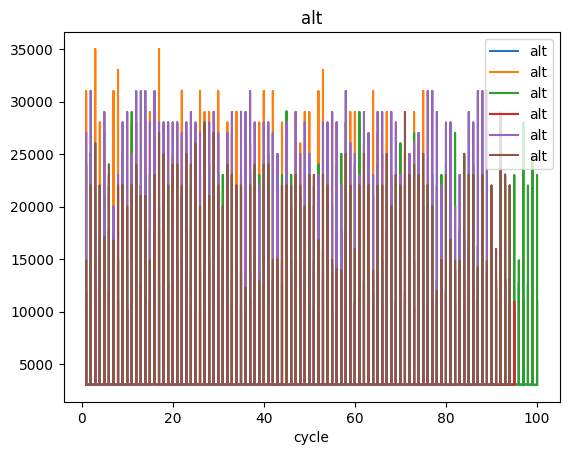

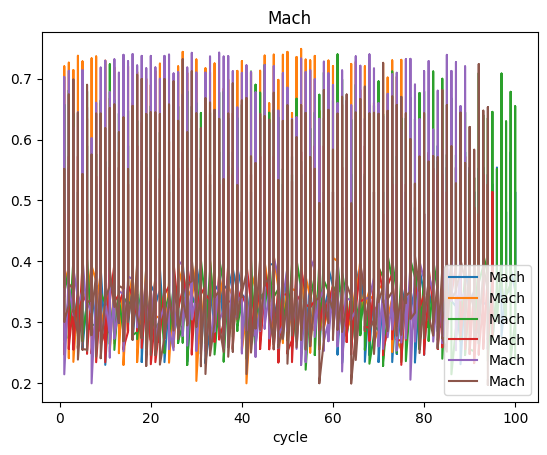

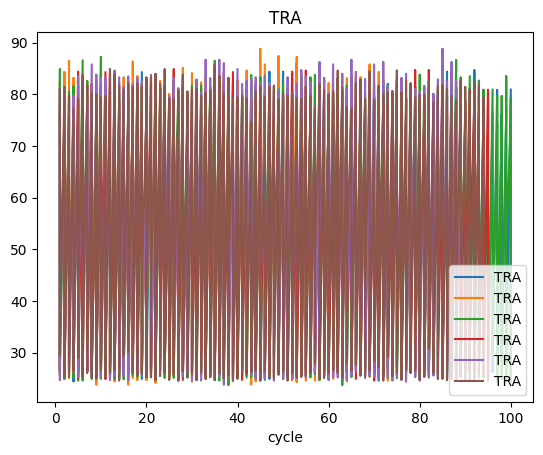

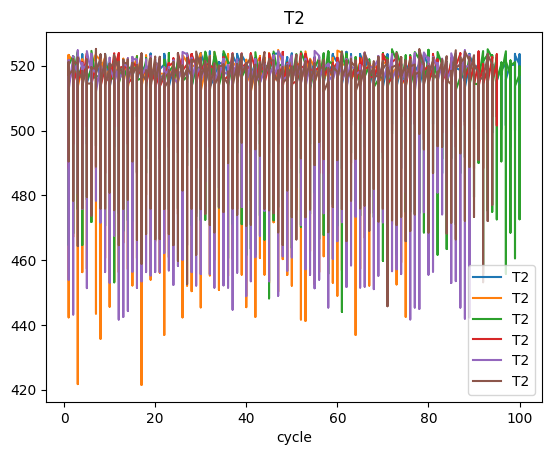

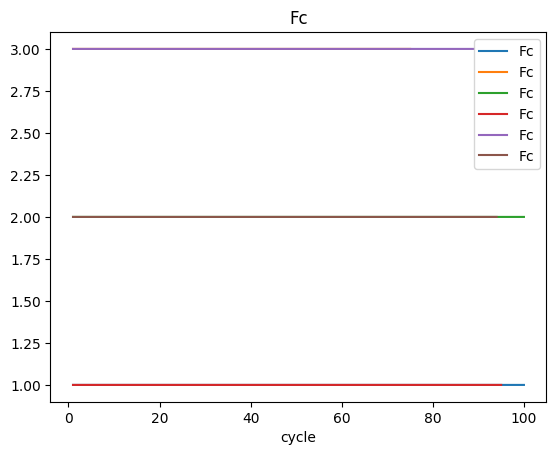

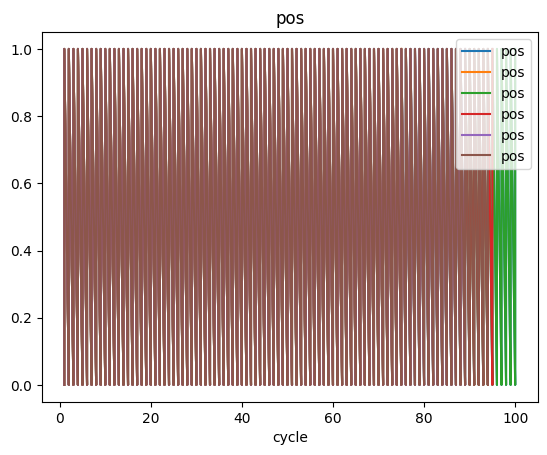

In [23]:
for col in operation_cond_cols:
    fig, ax = plt.subplots()
    df_downsampled.groupby("unit").plot(x="cycle",y=col, ax=ax,title=col,legend=True)
    plt.show()

## Get output healthy measurements/performances

* Sensor measurements: $Xs$
* Performance metrics: $T48$, $SmFan$, $SmLPC$, $SmHPC$

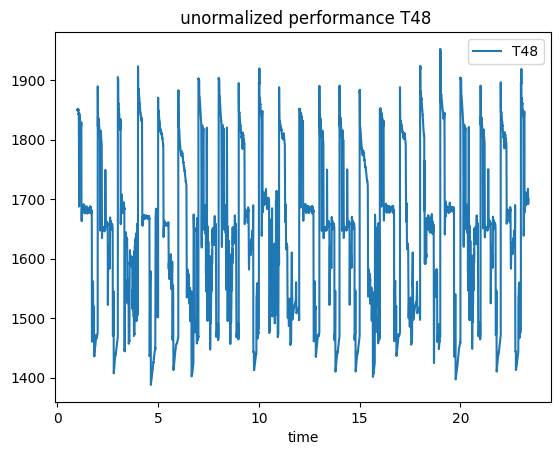

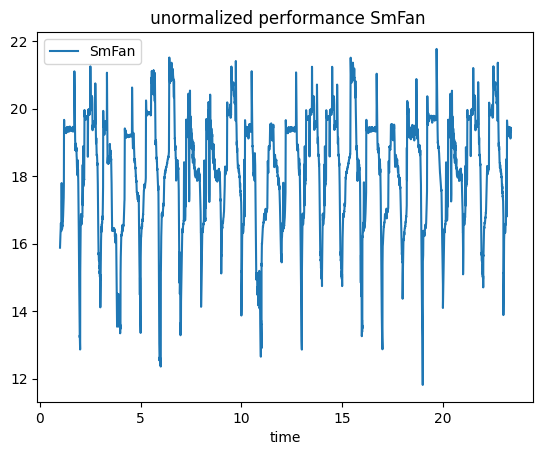

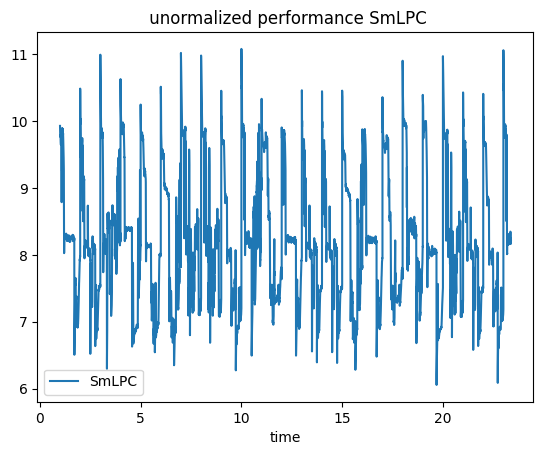

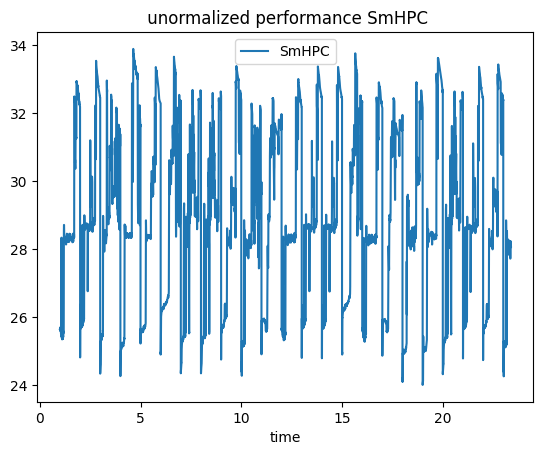

In [24]:
performance_cols = ['T48', 'SmFan','SmLPC','SmHPC']
df_downsampled['time']=df_downsampled['cycle']+df_downsampled['pos']
for perf in performance_cols:
    fig, ax = plt.subplots()
    ax.set_title(f" unormalized performance {perf}")
    df_downsampled[:10000].groupby("unit").plot(x="time", y=perf, ax=ax, legend=True)

## Save data 

In [25]:
os.makedirs(experiment_dir, exist_ok=True)

# save X and Y in dataset/healthy_Xs/
df_downsampled.to_csv(experiment_dir/f'data_{data_split}.csv', index=False)